# Write MNIST FASHION as TFRecords

This notebook converts the MNIST FASHION samples into TFRecords. TFRecords are used to feed large datasets into a Tensorflow model efficiently. You can read more about TFRecords and how to use them on this blog: https://goo.gl/4L365r

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
print(f'TF Version: {tf.__version__}')

TF Version: 1.8.0


## Load & Investigate dataset

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
print("Fashion MNIST:")
print("Training set (images) shape: {shape}".format(shape=train_images.shape))
print("Training set (labels) shape: {shape}".format(shape=train_labels.shape))

print("Test set (images) shape: {shape}".format(shape=test_images.shape))
print("Test set (labels) shape: {shape}".format(shape=test_labels.shape))

Fashion MNIST:
Training set (images) shape: (60000, 28, 28)
Training set (labels) shape: (60000,)
Test set (images) shape: (10000, 28, 28)
Test set (labels) shape: (10000,)


In [5]:
labels_lookup = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
                ]

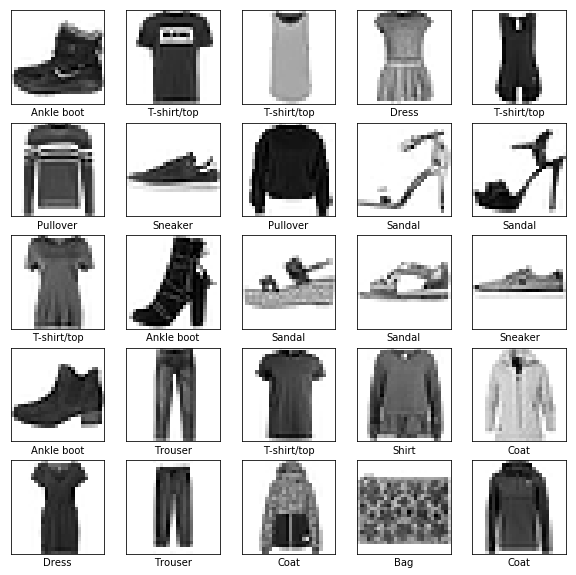

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(labels_lookup[train_labels[i]])

## Convert dataset to tfrecords

In [7]:
""" 
Converts MNIST data to TFRecords file format 
"""

import os

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def convert_mnist_fashion_dataset(images, labels, name, directory):
    import pathlib

    _, height, width = images.shape

    filename = os.path.join(directory, name + '.tfrecords')
    pathlib.Path(directory).mkdir(parents=True, exist_ok=True) 
    print(f'Writing {filename}')
    with tf.python_io.TFRecordWriter(filename) as writer: 
        for index in range(len(images)):
            image_raw = images[index].tostring()
            example = tf.train.Example(features=tf.train.Features(feature={
                'height': _int64_feature(height),
                'width': _int64_feature(width),
                'channels': _int64_feature(1), 
                'label': _int64_feature(int(labels[index])),
                'image_raw': _bytes_feature(image_raw)}))
            writer.write(example.SerializeToString())

In [8]:
convert_mnist_fashion_dataset(train_images, train_labels, 'train', 'data')
convert_mnist_fashion_dataset(test_images, test_labels, 'validation', 'data')

Writing data/train.tfrecords
Writing data/validation.tfrecords


## Write tfrecords to s3
We are going to upload the tfrecords to s3. Note that the upload_data function returns the s3url where the data will be stored. This url will later be used to feed data into the neural network during training.

In [9]:
import sagemaker

bucket = sagemaker.Session().default_bucket() # Automatically create a bucket
prefix = 'radix/mnist_fashion_tutorial' # Subfolder prefix

role = sagemaker.get_execution_role() 

s3_url = sagemaker.Session().upload_data(path='data', 
                                         bucket=bucket, 
                                         key_prefix=prefix+'/data/mnist')
print(s3_url)

INFO:sagemaker:Created S3 bucket: sagemaker-eu-central-1-959924085179


s3://sagemaker-eu-central-1-959924085179/radix/mnist_fashion_tutorial/data/mnist
